TODO:
Skrive små afsnit!
- Husk ord som:
- uni-direction/bi-directional
- connected graph

Breath-first-search implimentation


- **Jaccard and Adamic/adar score for party-sub networks**
- **Jaccard, SMA/RAND, etc score between caucuses and best partition**
- **Interpetation of best partition**


In [1]:
import numpy as np
import pandas as pd

import requests
from bs4 import BeautifulSoup

import networkx as nx
#import nxviz as nv

#import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
import graphviz

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from functools import reduce

from congress import Congress
import pickle

import community
import itertools

from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import adjusted_rand_score

# ------------------------------------------

#data_set = pd.read_csv("friends.csv", index_col=0)

pkl_file = open('/home/polichinel/Dropbox/credential/essentials.pkl', 'rb')
essentials = pickle.load(pkl_file)

congress = Congress(essentials["congress_key"]) # use your own congress key

pkl_file.close()

house = congress.members.filter("house")
house_members = house[0]['members']

df_house = pd.DataFrame(house_members)

reps = df_house.twitter_account

reps.dropna(inplace=True)

# for metadata:

repulicans = [i for i in list(df_house[df_house.party == "R"]["twitter_account"]) if i] # remove None_type hack -> men none types er vel indies
democrats = [i for i in list(df_house[df_house.party == "D"]["twitter_account"]) if i] # remove None_type hack


In [2]:
set(df_house.party) # hvor kommer ingen indies!

{'D', 'R'}

In [3]:
pkl_file = open('edges_RepRyanZinke.pkl', 'rb')
edges = pickle.load(pkl_file)
pkl_file.close()

In [4]:
caucus_df=pd.read_csv("caucus_twitterids.csv", index_col=0)

In [5]:
G = nx.Graph()
G.add_edges_from(edges) # Indies må komme herfra! Der må være edges som du ikke har nodes på....
G.add_nodes_from(repulicans, party = "R", party_int = 0)
G.add_nodes_from(democrats, party = "D", party_int = 1)

no_party = []

for i, p in list(G.nodes(data=True)):
    if len(p) == 0:
        no_party.append(i)
        
G.remove_nodes_from(no_party) # det er nok det her der burde ske.. men så skal low_degree ind efter...

#G.add_nodes_from(no_party, party = "non", party_int = 2)


low_degree = []

for i in list(G.degree()):
    if i[1] < 1: # a bit high..
        low_degree.append(i[0])
        
G.remove_nodes_from(low_degree)


R_nodes = [n for n, p in list(G.nodes(data=True)) if p['party'] == 'R']
D_nodes =  [n for n, p in list(G.nodes(data=True)) if p['party'] == 'D']
#N_nodes =  [n for n, p in list(G.nodes(data=True)) if p['party'] == 'non']

# kunne også være et andet ste, men nu er du jo igang her..
voting_with_party = dict(df_house[["twitter_account","votes_with_party_pct"]].dropna().to_dict(orient='split')["data"])
nx.set_node_attributes(G, voting_with_party, "voting_with_party_pct")

In [6]:
#N_nodes # så skal vi finde ud af hvor de hører til..

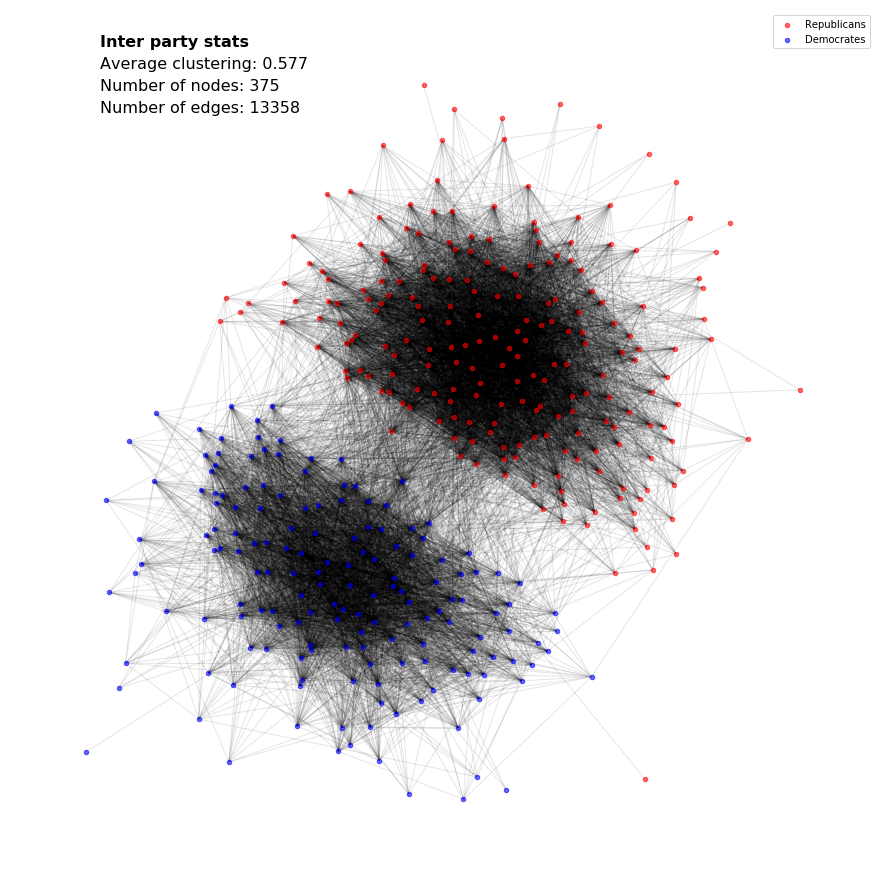

0.5773428397950628
375
13358


In [7]:
plt.axes([2,3,2,3])

#nx.draw(G, with_labels=True, font_weight='bold', alpha=0.6, pos = graphviz_layout(G))

pos = graphviz_layout(G)
#pos = nx.spring_layout(G)

nx.draw_networkx_edges(G, node_size=12, alpha = 0.1, pos=pos)

nx.draw_networkx_nodes(G, font_size=8, nodelist=R_nodes , node_size=20, node_color="red", alpha = 0.6, pos=pos, label = "Republicans", fontsize = 16)
nx.draw_networkx_nodes(G, font_size=8, nodelist=D_nodes , node_size=20, node_color="blue", alpha = 0.6, pos=pos, label = "Democrates", fontsize = 16)
#nx.draw_networkx_nodes(G, font_size=8, nodelist=N_nodes , node_size=20, node_color="cyan", alpha = 0.6, pos=graphviz_layout(G), label = "mis_class") 

plt.text(-150, 185, "Inter party stats", fontsize = 16, weight = "bold")
plt.text(-150, 175, "Average clustering: " + str(round(nx.average_clustering(G), 3)), fontsize = 16)
plt.text(-150, 165, "Number of nodes: " + str(len(G.nodes())), fontsize = 16)
plt.text(-150, 155, "Number of edges: " + str(len(G.edges())), fontsize = 16)


plt.legend()
plt.xticks(())
plt.yticks(())
sns.despine(left=True, bottom=True)

plt.savefig('party_net.pdf', bbox_inches="tight")
plt.show()


nx.write_gexf(G, "party_net.gexf", version="1.2draft")

print(nx.average_clustering(G)) # tolkning, tak.
print(len(G.nodes()))
print(len(G.edges()))

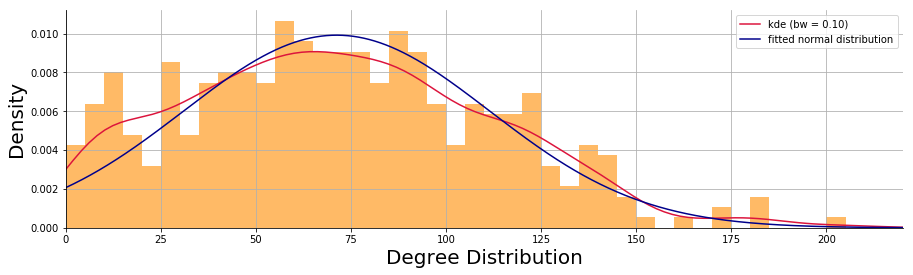

In [8]:
plt.figure(figsize=[15,4])

plt.hist(list(dict(G.degree()).values()), bins=np.arange(0,220,5), alpha = 0.6, color= "darkorange", density= True)

sns.kdeplot(list(dict(G.degree()).values()), label = "kde (bw = 0.10)", bw=10, color="crimson")
G_norm = stats.norm(np.mean(list(dict(G.degree()).values())),np.std(list(dict(G.degree()).values())))
grid = np.arange(0,220,0.1)
plt.plot(grid,G_norm.pdf(grid), color = "darkblue", label = "fitted normal distribution")

plt.grid()
plt.xlim(0,220)
plt.xlabel("Degree Distribution", fontsize = 20)
plt.ylabel("Density", fontsize = 20)
sns.despine()
plt.legend()

plt.savefig('party_net_degree.pdf', bbox_inches="tight")
plt.show()

----

# More stats

In [9]:
# nu som meta/atrributes, hvis det skal bruges... Størrelse på nodes?
bb = nx.betweenness_centrality(G)
dg = dict(nx.degree(G))
dgc = nx.degree_centrality(G)

nx.set_node_attributes(G, dg, "degree")
nx.set_node_attributes(G, dgc, "degree_cent")
nx.set_node_attributes(G, bb, "betweenness_cent")

In [10]:
# But do you also need a caucus_num_dict
caucus_dict = {}

for i in range(caucus_df.shape[0]):
    caucus_dict[caucus_df[["caucus","twitter_id"]].iloc[i][1]] = caucus_df[["caucus","twitter_id"]].iloc[i][0]
    
# note; not all of the house-members are in the caucus set... 419 vs 449
nx.set_node_attributes(G, caucus_dict, "caucus")

In [11]:
#G.nodes(data = "caucus")


# Degree centrality

$$
\frac{\text{number of nieghbours a node has}}{\text{number of nieghbours a nodes could possibly have}}
$$

If there is no self-loops then the max number of nieghbours a node can have is $all\_nodes - self$
captures highly conncted nodes.


# Betweenness centrality

$$
\frac{\text{num. shortets paths through node}}{\text{all possible shortest paths}}
$$

Captures bottlesneck-nodes rather then highly connnected nodes.

Used to find individuels wich bridge two communites, e.g. conservatives and liberals

Kan gøre gøre noget med udviklinge her? Hvor meget entropy der er? Eller noget..

In [12]:
communities = community.best_partition(G) # det gør du igen senere...

DG = pd.DataFrame(pd.Series(dict(nx.degree(G)))).reset_index().rename(columns={'index': 'rep', 0: 'degree'})
DC = pd.DataFrame(pd.Series(nx.degree_centrality(G))).reset_index().rename(columns={'index': 'rep', 0: 'degree_cent'})
BC = pd.DataFrame(pd.Series(nx.betweenness_centrality(G))).reset_index().rename(columns={'index': 'rep', 0: 'betweenness_cent'})
COM = pd.DataFrame(pd.Series(communities)).reset_index().rename(columns={'index': 'rep', 0: 'Louvian_communities'})


net_stats = BC.merge(DC)
net_stats = net_stats.merge(DG)
net_stats = net_stats.merge(COM)


sub_house = df_house[["party","twitter_account"]]
sub_house.columns = ["party", "rep"]

net_stats = net_stats.merge(sub_house)

net_stats.sample(6)


,rep,betweenness_cent,degree_cent,degree,Louvian_communities,party
212,RepKihuen,0.000904,0.104278,39,1,D
352,SpeakerRyan,0.019448,0.491979,184,0,R
174,RepJasonLewis,0.000112,0.032086,12,0,R
129,RepDerekKilmer,0.000242,0.066845,25,1,D
125,RepDebDingell,0.008410,0.294118,110,1,D
99,RepChrisCollins,0.004318,0.237968,89,0,R


Looking at the most central house_mmembers from each party:
(you need the three features for the plot)

## HIGHS

In [13]:
# for checks and the plot futher down

high_DC_R = net_stats[net_stats["party"] == "R"][["rep","degree_cent","betweenness_cent","party"]].sort_values("degree_cent", ascending=False)[:3]
high_BC_R = net_stats[net_stats["party"] == "R"][["rep","betweenness_cent","degree_cent","party"]].sort_values("betweenness_cent", ascending=False)[:3]
high_DC_D = net_stats[net_stats["party"] == "D"][["rep","degree_cent","betweenness_cent","party"]].sort_values("degree_cent", ascending=False)[:3]
high_BC_D = net_stats[net_stats["party"] == "D"][["rep","betweenness_cent","degree_cent","party"]].sort_values("betweenness_cent", ascending=False)[:3]
highs = [high_BC_D, high_BC_R, high_DC_D, high_DC_R]


all_top_5 = reduce(lambda left,right: pd.merge(left,right, how= "outer"), highs) # for plot anotation 
all_top_5.sort_values("betweenness_cent", ascending= False , inplace=True)

#all_top_5
#high_DC_R
#high_BC_R
#high_DC_D
#high_BC_D

## A bit of discribtion:

In [14]:
# nodes 
count_nodes = pd.DataFrame(dict(G.nodes(data="party")), index= np.arange(1)).T
print(len(count_nodes[count_nodes[0]=="D"]))
print(len(count_nodes[count_nodes[0]=="R"]))

162
213


In [15]:
# for Asgers script
count_nodes2 = count_nodes.reset_index()
count_nodes2.columns = {"twitter_id":"Index", "party":0}
count_nodes2.to_csv("all_twitter_ids_final_network.csv")

In [16]:
#Actual house_members
print(len(df_house[df_house["party"] == "D"]["party"]))
print(len(df_house[df_house["party"] == "R"]["party"]))

200
249


In [17]:
net_stats.describe() 

,betweenness_cent,degree_cent,degree,Louvian_communities
count,375.000000,375.000000,375.000000,375.000000
mean,0.002506,0.190488,71.242667,0.445333
std,0.004158,0.107650,40.260944,0.508298
min,0.000000,0.002674,1.000000,0.000000
25%,0.000463,0.109626,41.000000,0.000000
50%,0.001317,0.184492,69.000000,0.000000
75%,0.003062,0.262032,98.000000,1.000000
max,0.040450,0.545455,204.000000,2.000000


In [18]:
net_stats.pivot_table(values=["betweenness_cent", "degree_cent", "degree", "Louvian_communities"], index="party", margins=True)


,Louvian_communities,betweenness_cent,degree,degree_cent
party,,,,
D,1.000000,0.002702,68.129630,0.182165
R,0.023474,0.002357,73.610329,0.196819
All,0.445333,0.002506,71.242667,0.190488


See the Louvian_communities are pefectly split between parties. This is plotted later again.

In [19]:
net_stats.pivot_table(values=["degree"], index="party", aggfunc=sum, margins=True) # så det er edges * 2!

,degree
party,
D,11037
R,15679
All,26716


# Stat histograms

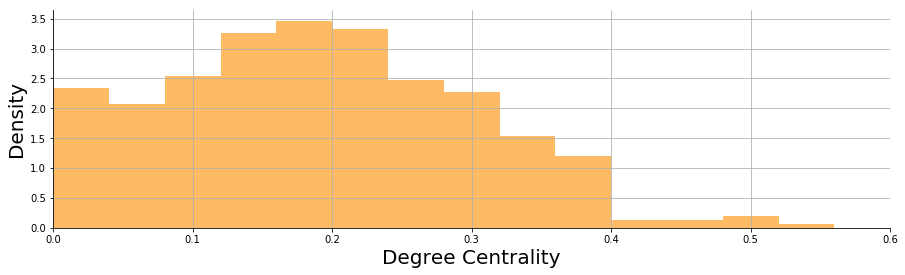

In [20]:
plt.figure(figsize=[15,4])
plt.hist(net_stats["degree_cent"], bins=np.arange(0,0.6,0.04), alpha = 0.6, color= "darkorange", density=True)


plt.grid()
plt.xlim(0,0.6)
plt.xlabel("Degree Centrality", fontsize = 20)
plt.ylabel("Density", fontsize = 20)
sns.despine()
#plt.legend()

plt.savefig('party_net_DC.pdf', bbox_inches="tight")
plt.show()

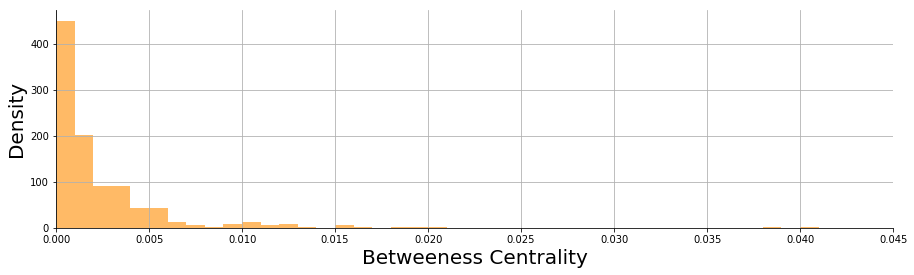

In [21]:
plt.figure(figsize=[15,4])
plt.hist(net_stats["betweenness_cent"], bins=np.arange(0,0.045,0.001), alpha = 0.6, color= "darkorange", density=True)


plt.grid()
plt.xlim(0,0.045)
plt.xlabel("Betweeness Centrality", fontsize = 20)
plt.ylabel("Density", fontsize = 20)
sns.despine()
#plt.legend()

plt.savefig('party_net_BC.pdf', bbox_inches="tight")
plt.show()

# Stats scatter

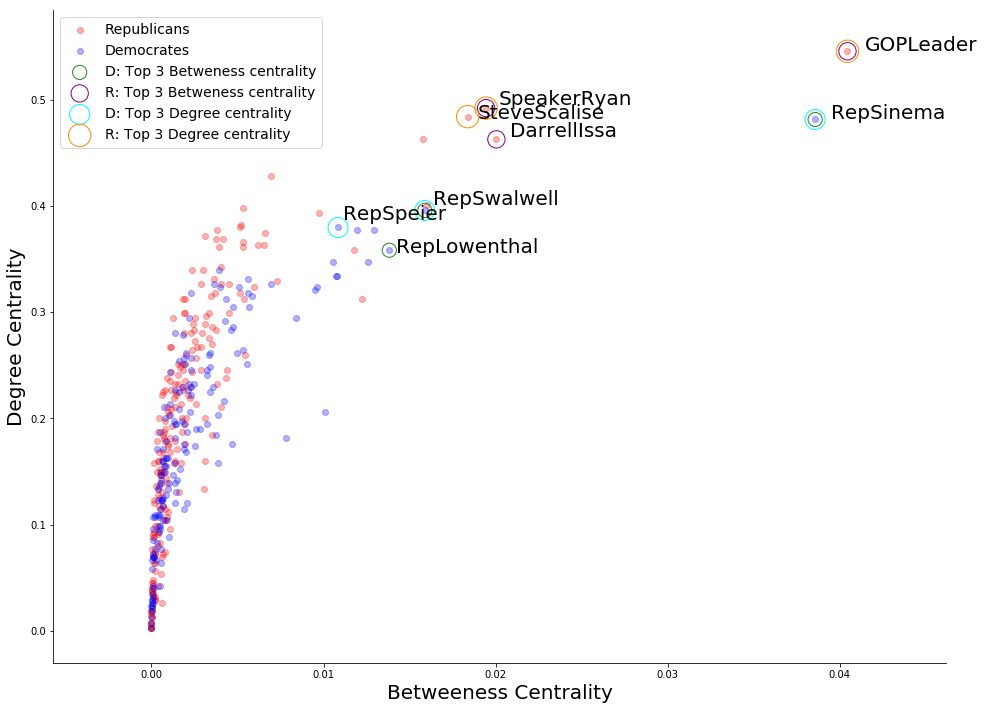

In [22]:
RL = net_stats[net_stats.party == "R"]
DL = net_stats[net_stats.party == "D"]

party_list = [RL,DL]

# highs = [high_BC_D, high_BC_R, high_DC_D, high_DC_R] # er højere oppe nu

plt.figure(figsize = [16,12])


my_colors = ["red","blue"]
my_colors2 = ["forestgreen","purple","cyan", "darkorange"]

labels = ["Republicans", "Democrates"]
labels2 = ["D: Top 3 Betweness centrality","R: Top 3 Betweness centrality","D: Top 3 Degree centrality","R: Top 3 Degree centrality"]

for i in range(len(party_list)):
    plt.scatter(party_list[i].betweenness_cent, party_list[i].degree_cent, alpha = 0.3, color = my_colors[i], label = labels[i])
    
#     for j in range(len(highs)):
#         plt.scatter(party_list[i][party_list[i].isin(highs[j])].betweenness_cent,
#                     party_list[i][party_list[i].isin(highs[j])].degree_cent,  s=200+j*100, facecolors='none', edgecolors=my_colors2[j], label = highs[j])
        
for j in range(len(highs)):
    plt.scatter(net_stats[net_stats.isin(highs[j])].betweenness_cent,
                net_stats[net_stats.isin(highs[j])].degree_cent,  s=200+j*100, facecolors='none', edgecolors=my_colors2[j], label = labels2[j])

    
# ------------------------------------------------------------------------------------
# the whole count and if thing is just to avoide to much cluttering of names
count1 = 0
count2 = 0

for k in all_top_5.rep:
    if k in ["WhipHoyer", "RepLowenthal", "RepGaramendi","SteveScalise"]: # Might change as you get more data!

        plt.annotate(k, 
                 xy=(all_top_5[all_top_5.rep == k]["betweenness_cent"] + 0.001 - count2
                     , all_top_5[all_top_5.rep == k]["degree_cent"]- 0.002 ), fontsize = 20) 
    
    else:
        plt.annotate(k, 
                 xy=(all_top_5[all_top_5.rep == k]["betweenness_cent"] + 0.001 - count2
                     , all_top_5[all_top_5.rep == k]["degree_cent"] + count1 ), fontsize = 20) 
    count1 += 0.001
    count2 += 0.0001
# -------------------------------------------------------------------------------------
    
    
#plt.scatter(high_BC_D.betweenness_cent, high_DC_D.degree_cent, s=200, facecolors='none', edgecolors="green")
sns.despine()
plt.xlabel("Betweeness Centrality", fontsize = 20)
plt.ylabel("Degree Centrality", fontsize = 20)


plt.legend(fontsize = 14)

plt.savefig('party_net_BC_DC_scatter.pdf', bbox_inches="tight")
plt.show()    

In [23]:
# top 10 reps BC
net_stats[net_stats["party"]=="R"][["rep","betweenness_cent"]].sort_values("betweenness_cent", ascending = False).head(10)

,rep,betweenness_cent
22,GOPLeader,0.040450
14,DarrellIssa,0.020046
352,SpeakerRyan,0.019448
355,SteveScalise,0.018378
140,RepErikPaulsen,0.016020
301,RepShimkus,0.015767
220,RepLeeZeldin,0.012264
178,RepJeffDuncan,0.011754
13,CongressmanGT,0.009725
306,RepStefanik,0.007316


In [24]:
# top 10 reps BC
net_stats[net_stats["party"]=="R"][["rep","degree_cent"]].sort_values("degree_cent", ascending = False).head(10)

,rep,degree_cent
22,GOPLeader,0.545455
352,SpeakerRyan,0.491979
355,SteveScalise,0.483957
14,DarrellIssa,0.462567
301,RepShimkus,0.462567
131,RepDianeBlack,0.427807
140,RepErikPaulsen,0.401070
330,RepTomPrice,0.398396
13,CongressmanGT,0.393048
41,MarshaBlackburn,0.382353


In [25]:
# top 10 dems BC
net_stats[net_stats["party"]=="D"][["rep","betweenness_cent"]].sort_values("betweenness_cent", ascending = False).head(10)

,rep,betweenness_cent
302,RepSinema,0.038572
313,RepSwalwell,0.015888
229,RepLowenthal,0.013821
372,WhipHoyer,0.012913
149,RepGaramendi,0.012575
98,RepCheri,0.011964
305,RepSpeier,0.010844
316,RepTedLieu,0.010757
319,RepTerriSewell,0.010702
5,BobbyScott,0.010578


In [26]:
# top 10 dems DC
net_stats[net_stats["party"]=="D"][["rep","degree_cent"]].sort_values("degree_cent", ascending = False).head(10)

,rep,degree_cent
302,RepSinema,0.481283
313,RepSwalwell,0.395722
305,RepSpeier,0.379679
372,WhipHoyer,0.377005
98,RepCheri,0.377005
229,RepLowenthal,0.358289
149,RepGaramendi,0.347594
5,BobbyScott,0.347594
72,RepBarbaraLee,0.339572
319,RepTerriSewell,0.334225


# Find the leaders:

In [27]:
#So this is not the most readerble or elegant data handling, but it's quick and it works

names = df_house[["party","first_name","middle_name","last_name","twitter_account"]].copy()
names["middle_name"]  = names["middle_name"].fillna("")
names["name"] = names["first_name"] + " " + names["middle_name"] + " " + names["last_name"]
names.drop(["middle_name", "first_name" , "last_name"], axis=1, inplace= True)

leaders = df_house["leadership_role"].unique()
leaders_twitter = list(df_house[df_house["leadership_role"].isin(leaders[2:])]["twitter_account"]) # [2:] to remove "None" and ""

# a new nets to not mess up any work I'v done later on.
net_stats2 = net_stats.copy()
net_stats2.rename(columns={"rep":"twitter_account"}, inplace=True)
names = names.merge(net_stats2)

# rank --------------------------------------------------------

rank_bc = names.sort_values("betweenness_cent", ascending= False).reset_index()[["twitter_account"]].reset_index() # making the a ranking column with a pandas hack
rank_bc.rename(columns={"index":"rank_bc"}, inplace= True)

rank_dc = names.sort_values("degree_cent", ascending= False).reset_index()[["twitter_account"]].reset_index() # making the a ranking column with a pandas hack
rank_dc.rename(columns={"index":"rank_dc"}, inplace= True)

names = names.merge(rank_dc)
names = names.merge(rank_bc)

# ----------------------------------------------
leaders_df = df_house[df_house["leadership_role"].isin(leaders[2:])][["twitter_account", "leadership_role"]] # [2:] to remove "None" and ""
names_leaders = names.merge(leaders_df)

# -----------------------------------------------
names_leaders[names_leaders["twitter_account"].isin(leaders_twitter)].sort_values("party", ascending= False)


,party,twitter_account,name,betweenness_cent,degree_cent,degree,Louvian_communities,rank_dc,rank_bc,leadership_role
2,R,GOPLeader,Kevin McCarthy,0.040450,0.545455,204,0,0,0,Majority Leader
3,R,RepLukeMesser,Luke Messer,0.001951,0.235294,88,0,123,136,Policy Committee Chair
5,R,SpeakerRyan,Paul D. Ryan,0.019448,0.491979,184,0,1,3,Speaker of the House
6,R,SteveScalise,Steve Scalise,0.018378,0.483957,181,0,2,4,Majority Whip
0,D,Clyburn,James E. Clyburn,0.002286,0.318182,119,1,52,119,Assistant Leader
1,D,WhipHoyer,Steny H. Hoyer,0.012913,0.377005,141,1,15,9,Minority Whip
4,D,NancyPelosi,Nancy Pelosi,0.005606,0.318182,119,1,49,33,Minority Leader


Shouldthe ranking be seperated by party?

# Jaccard and Adamic/Adar (for predictions)

The **Jaccard** coeficient - in a network setting - mearsurement for the numbers of common neighbors between to nodes. That is, to what extent does $node_1$'s set of nieghors overlab with $node_2$'s set of nieghbors:

$$
\text{score}(node_1,node_2) :=
\frac
{|\Gamma(node_1)\cap\Gamma(node_2)|}
{|\Gamma(node_1)\cup\Gamma(node_2)|}
$$

(rigth?)

In [28]:
# Jaccard:
jaccard = list(nx.algorithms.link_prediction.jaccard_coefficient(G))
jaccard_df = pd.DataFrame(jaccard)
# pd.Series(jaccard).isna().any()


jaccard_df[3] = jaccard_df[0] + "_" + jaccard_df[1]
jaccard_df.columns = {"pol_one":0,"pol_two":1,"jaccard":2, "dyad":3}
jaccard_df.sample(6)

,pol_one,pol_two,jaccard,dyad
20244,RepWilson,RepBlainePress,0.006494,RepWilson_RepBlainePress
17601,RepDebDingell,SteveKnight25,0.000000,RepDebDingell_SteveKnight25
15915,RepBost,NancyPelosi,0.020305,RepBost_NancyPelosi
20611,RepZoeLofgren,RepHalRogers,0.000000,RepZoeLofgren_RepHalRogers
19481,CongCulberson,USRepRodney,0.046154,CongCulberson_USRepRodney
33806,BobbyScott,RepBillFoster,0.458599,BobbyScott_RepBillFoster


In [29]:
jaccard_df.shape


(56767, 4)

In [30]:
# måske relevant of at sætte nul in? -> ellers må det være lettere at gøre senere

# really no need for this matrix
# jaccard_mat_df = jaccard_df.pivot_table(index=0, columns = 1, fill_value= 0) #
# jaccard_mat_df.columns = jaccard_mat_df.columns.droplevel()
# jaccard_mat_df.sample(6)

# plt.axes([2,2,2,2])

# sns.heatmap(jaccard_mat_df)

# plt.xticks(())
# plt.yticks(())
# plt.show()

The **Ademic/Adar** coeficients is a somewhat related measure. It is defined as shuch:

$$
\sum_{\text{z : neighbors shared by }node_1,node_2}
\frac
{1}
{log(frequency(z))}
$$

The point is that this measurement gives a higer wieght to rarely shared neighbors, such that:

$$
\text{score}(node_1,node_2):=
\sum_{z\in\Gamma(node_1)\cap\Gamma(node_2)}
\frac
{1}
{log|\Gamma(z)|}
$$

In studie XXX YYY found that it out performed Jaccard coeficeint.

In [31]:
ademic = list(nx.algorithms.link_prediction.adamic_adar_index(G))
ademic_df = pd.DataFrame(ademic)


ademic_df[3] = ademic_df[0] + "_" + ademic_df[1]
ademic_df.columns = {"pol_one":0,"pol_two":1,"ademic":2, "dyad":3}
#ademic_df.sample(6)

In [32]:
ademic_df.shape

(56767, 4)

In [33]:
jaccard_ademic_df = ademic_df.merge(jaccard_df)
cols = ['pol_one', 'pol_two', 'dyad', 'ademic', 'jaccard'] # get original: cols = jaccard_ademic_df.columns.tolist()
jaccard_ademic_df = jaccard_ademic_df[cols]
#jaccard_ademic_df.sample(6)

In [34]:
# for the final prediction problem
jaccard_ademic_df.to_csv("jaccard_adamic_df.csv")

# So, this data is ready to be merged with Asgers
- almost needs ID..

In [35]:
# martix if relevant

# ademic = list(nx.algorithms.link_prediction.adamic_adar_index(G))
# ademic_df = pd.DataFrame(ademic)

# ademic_mat_df = ademic_df.pivot_table(index=0, columns = 1, fill_value= 0) # fill alright?
# ademic_mat_df.columns = ademic_mat_df.columns.droplevel()
# ademic_mat_df.sample(6)

# plt.axes([2,2,2,2])

# sns.heatmap(ademic_mat_df)

# plt.xticks(())
# plt.yticks(())
# plt.show()

# Average coef between R and D:
(some smart loop)

In [36]:
party_list_scores = []

for i in range(jaccard_df.shape[0]):
    if jaccard_df["pol_one"][i] in repulicans:
        party_list_scores.append("R")
    else:
        party_list_scores.append("D")

jaccard_df["party_of_node"] =  party_list_scores
        
party_list_scores = []

for i in range(jaccard_df.shape[0]):
    if jaccard_df["pol_two"][i] in repulicans:
        party_list_scores.append("R")
    else:
        party_list_scores.append("D")
        
jaccard_df["party_of_neighbor"] =  party_list_scores
#jaccard_df.columns = {"node":0, "neighbor": 1, "jaccard_score" : 2, "party_of_node":"party_of_node", "party_of_neighbor":"party_of_neighbor"}


In [37]:
print(jaccard_df[jaccard_df.party_of_node == "R"]["jaccard"].mean())
print(jaccard_df[jaccard_df.party_of_node == "D"]["jaccard"].mean())


0.09466082781321788
0.0765452402273098


In [38]:
party_list_scores = []

for i in range(len(ademic_df["pol_one"])):
    if ademic_df["pol_one"][i] in repulicans:
        party_list_scores.append("R")
    else:
        party_list_scores.append("D")

ademic_df["party_of_node"] =  party_list_scores
        
party_list_scores = []

for i in range(len(ademic_df["pol_two"])):
    if ademic_df["pol_two"][i] in repulicans:
        party_list_scores.append("R")
    else:
        party_list_scores.append("D")
        
ademic_df["party_of_neighbor"] =  party_list_scores

#ademic_df.columns = {"node":0, "neighbor": 1, "ademic_score" : 2, "party_of_node":"party_of_node", "party_of_neighbor":"party_of_neighbor"}


In [39]:
print(ademic_df[ademic_df.party_of_node == "R"]["ademic"].mean())
print(ademic_df[ademic_df.party_of_node == "D"]["ademic"].mean())


2.4827583574917322
1.9362714612654761


# Modularity:

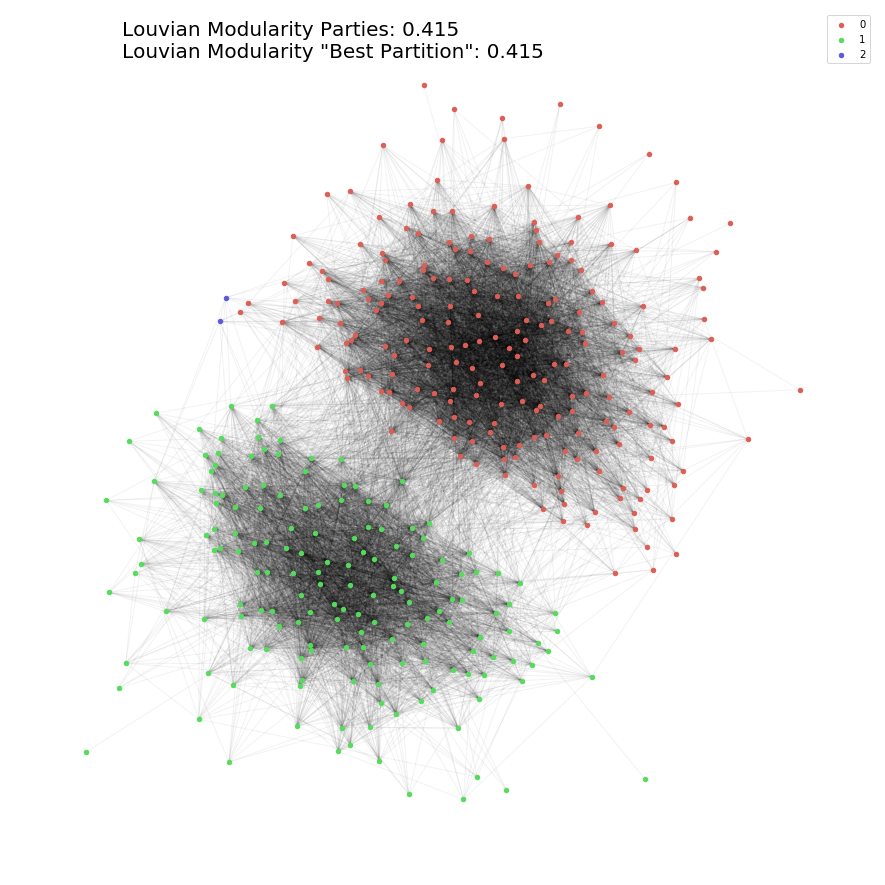

In [40]:
plt.axes([2,3,2,3])

parties = dict(G.nodes(data="party_int"))
communities = community.best_partition(G)
modularity_best_pat = community.modularity(communities, G) 
modularity_parties = community.modularity(parties, G) # virker først når du har ordnet det med små og store bogstaver...

n_communities = len(set(list(communities.values())))
my_colors = sns.color_palette("hls", n_communities)
count = 0

pos=graphviz_layout(G)

for com in set(communities.values()):
        list_nodes = [nodes for nodes in communities.keys() if communities[nodes] == com]
        
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20, node_color = my_colors[count], label = str(com))
        
        count += 1

#nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20, node_color = my_colors[count], label = str(com))

        
plt.text(-140, 180, 'Louvian Modularity "Best Partition": ' + str(round(modularity_best_pat,3)), fontsize = 20)
plt.text(-140, 190, "Louvian Modularity Parties: " + str(round(modularity_parties,3)), fontsize = 20) # virker først når du har ordnet det med små og store bogstaver...

nx.draw_networkx_edges(G,pos, alpha=0.05)

plt.legend()
plt.xticks(())
plt.yticks(())
sns.despine(left=True,bottom=True)
plt.savefig('Louvian_net.pdf', bbox_inches="tight")

plt.show()

Hvordan finder du de mest politikkere der er mest connected på tværs af communities?

In [41]:
# remove nons and outliers:
GV = G.copy()

non = []

for node in GV.nodes(data="voting_with_party_pct"):
    if node[1] == None:
        non.append(node[0])

GV.remove_nodes_from(non)

low_score = []

for node in GV.nodes(data="voting_with_party_pct"): # treshold
    if node[1] < 67:
        low_score.append(node[0])

GV.remove_nodes_from(low_score)

In [42]:
G = nx.Graph()
G.add_edges_from(edges) # Indies må komme herfra! Der må være edges som du ikke har nodes på....
G.add_nodes_from(repulicans, party = "R", party_int = 0)
G.add_nodes_from(democrats, party = "D", party_int = 1)

no_party = []

for i, p in list(G.nodes(data=True)):
    if len(p) == 0:
        no_party.append(i)
        
G.remove_nodes_from(no_party) # det er nok det her der burde ske.. men så skal low_degree ind efter...

#G.add_nodes_from(no_party, party = "non", party_int = 2)


low_degree = []

for i in list(G.degree()):
    if i[1] < 1: # a bit high..
        low_degree.append(i[0])
        
G.remove_nodes_from(low_degree)


R_nodes = [n for n, p in list(G.nodes(data=True)) if p['party'] == 'R']
D_nodes =  [n for n, p in list(G.nodes(data=True)) if p['party'] == 'D']
#N_nodes =  [n for n, p in list(G.nodes(data=True)) if p['party'] == 'non']

# kunne også være et andet ste, men nu er du jo igang her..
voting_with_party = dict(df_house[["twitter_account","votes_with_party_pct"]].dropna().to_dict(orient='split')["data"])
nx.set_node_attributes(G, voting_with_party, "voting_with_party_pct")

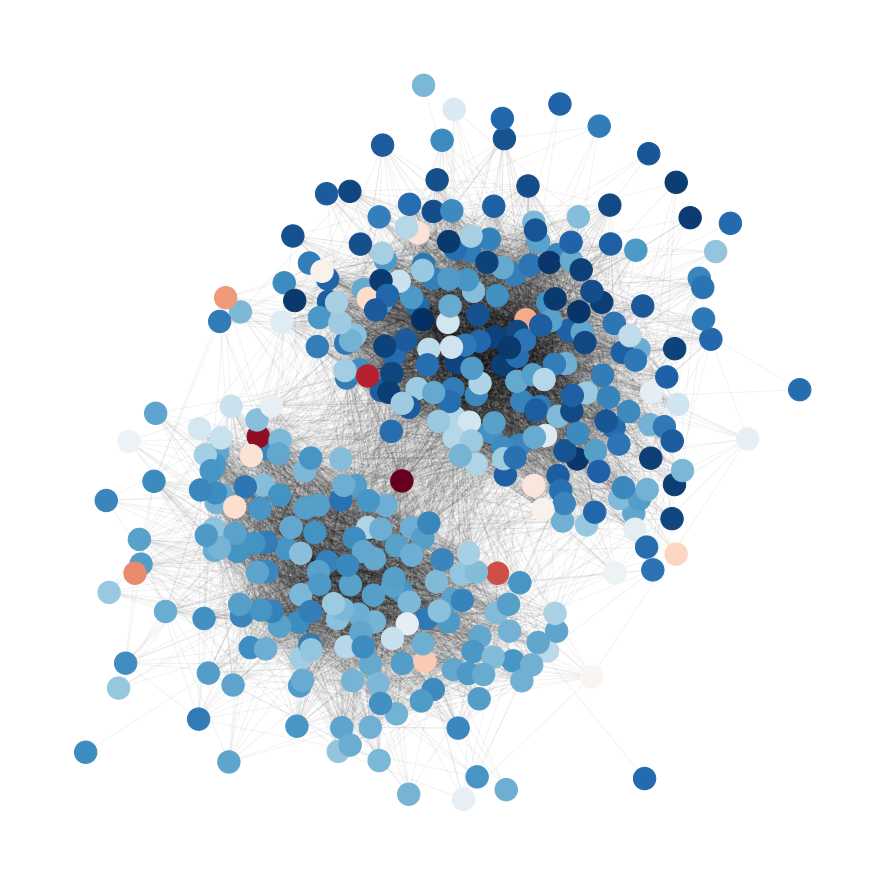

In [43]:
plt.axes([2,3,2,3])

val_map = dict(GV.nodes(data = "voting_with_party_pct"))

values = [val_map.get(node) for node in GV.nodes()]
n_val = len(set(values))
#nx.draw(G, cmap = plt.get_cmap('Blues'), node_color=values, pos = pos, node_size=20)
nx.draw_networkx_nodes(GV, cmap = plt.get_cmap('RdBu', n_val), node_color=values, pos = pos, node_size=500, alpha= 1)
nx.draw_networkx_edges(GV,pos, alpha=0.05)

plt.xticks(())
plt.yticks(())

sns.despine(left=True, bottom=True)
plt.show()

In [44]:
df_house[(df_house["votes_with_party_pct"] > 67) & (df_house["twitter_account"] != "None")]\
[["twitter_account","party","votes_with_party_pct"]].sort_values("votes_with_party_pct").head(10)

,twitter_account,party,votes_with_party_pct
383,RepSinema,D,77.42
91,RepCuellar,D,78.62
263,RepThomasMassie,R,79.83
132,repbrianfitz,R,80.94
84,RepJimCosta,D,81.21
156,RepJoshG,D,82.98
244,RepLoBiondo,R,83.51
360,SpeakerRyan,R,84.00
289,RepStephMurphy,D,85.31
346,RosLehtinen,R,85.75


**RepSinema:** Official Twitter feed of U.S. Congresswoman Kyrsten Sinema, serving Arizona's 9th District.

In [45]:
# The three "outliers":
df_house[(df_house["votes_with_party_pct"] > 0) & (df_house["twitter_account"] != "None")]\
[["twitter_account","party","votes_with_party_pct"]].sort_values("votes_with_party_pct").head(3)

,twitter_account,party,votes_with_party_pct
326,RepTomPrice,R,33.33
203,RepWalterJones,R,61.27
288,RepMickMulvaney,R,66.67


Partion acordign to some theshholds and check the modularity?


**So here we see the modularity captures the two parties perfectly**

------------------------------------------
# THIS IS WHERE YOU ARE AT:

In [46]:
caucus_df=pd.read_csv("caucus_twitterids.csv", index_col=0)
print(caucus_df.shape)
caucus_df.sample(6)
# need to make a numeris caucus column..

(419, 3)


,caucus,name,twitter_id
52,Republican Study Committee,Francis Rooney,RepRooney
261,Blue Collar Caucus,Dave Loebsack,DaveLoebsack
21,Freedom Caucus,Warren Davidson,WarrenDavidson
172,Republican Study Committee,David Rouzer,RepDavidRouzer
123,Republican Study Committee,Lynn Jenkins,RepLynnJenkins
374,Congressional Progressive Caucus,Matt Cartwright,RepCartwright


# Spilliting the two sets

**Måske du herunder skullle fokusere kun på top 1? Så kan du også få navne ind....**

In [76]:
# Ja, det er lidt oprydning... Kunne være implimenteret tidligere og bedre.

df_temp1 = df_house[["twitter_account", "party"]]
df_temp1.columns = {"twitter_id":"twitter_account", "party" : "party"}

df_temp2 = caucus_df[["twitter_id", "caucus"]]

df_temp3 = df_temp1.merge(df_temp2)
df_temp3.columns = {"rep":"twitter_account", "party" : "party", "caucus" : "caucus"}
df_temp3.columns 

Index(['rep', 'party', 'caucus'], dtype='object')

In [77]:
nx.set_node_attributes(G, caucus_dict, "caucus") # HER, DU GJORT, MEN... du laver d om på vejen her ned??? hVAD HANDLER DET OM?

GR = G.subgraph(R_nodes)
GD = G.subgraph(D_nodes)

# Her var det du skulle bruge...
print(len(list(GR.nodes())))
print(len(list(GD.nodes())))

213
162


# R only

In [116]:
R_caucus = dict(GR.nodes(data="caucus"))
modularity_R_caucus = community.modularity(R_caucus, GR)
print(modularity_R_caucus)

0.0076885647008574035


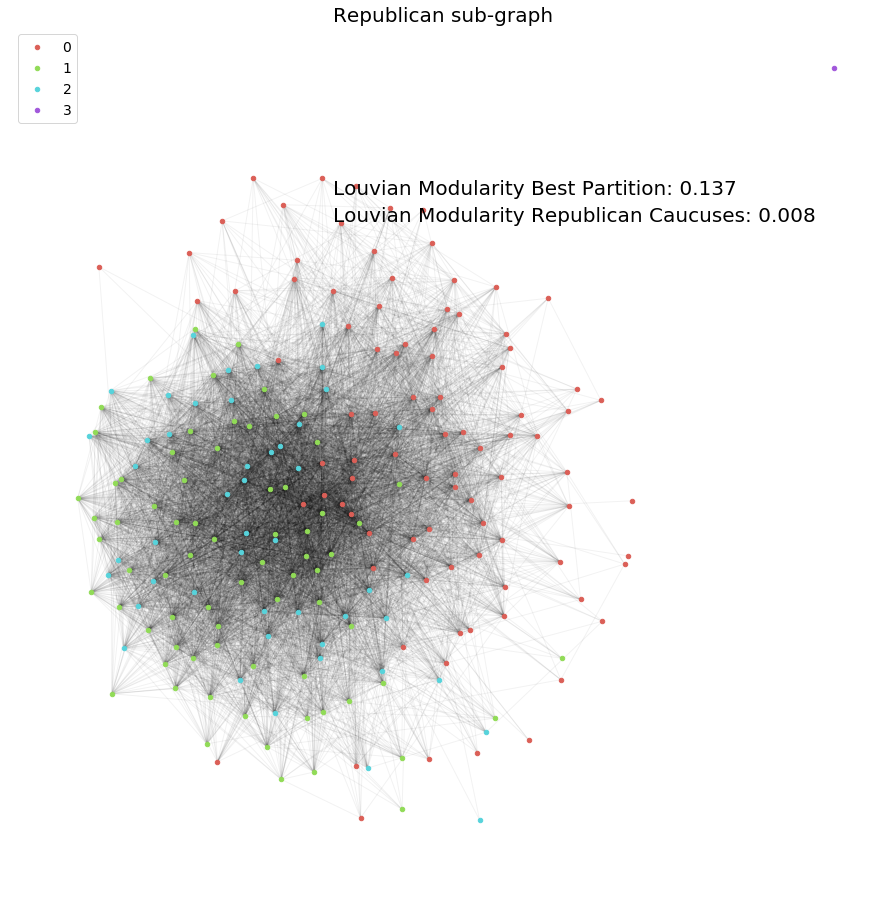

In [117]:
plt.axes([2,3,2,3])



communities = community.best_partition(GR)
modularity_best_pat = community.modularity(communities, GR) 

n_communities = len(set(list(communities.values())))
my_colors = sns.color_palette("hls", n_communities)
count = 0

pos=graphviz_layout(GR)

for com in set(communities.values()):
        list_nodes = [nodes for nodes in communities.keys() if communities[nodes] == com]
        
        nx.draw_networkx_nodes(GR, pos, list_nodes, node_size = 20, node_color = my_colors[count], label = str(com))
        
        count += 1

plt.text(-10, 100, "Louvian Modularity Best Partition: " + str(round(modularity_best_pat,3)), fontsize = 20)
plt.text(-10, 90, "Louvian Modularity Republican Caucuses: " + str(round(modularity_R_caucus,3)), fontsize = 20)

nx.draw_networkx_edges(GR,pos, alpha=0.05)

plt.title("Republican sub-graph", fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(())
plt.yticks(())
sns.despine(left=True,bottom=True)
plt.savefig('Louvian_Rnet.pdf', bbox_inches="tight")

plt.show()

In [118]:
rep_DG = pd.DataFrame(pd.Series(dict(nx.degree(GR)))).reset_index().rename(columns={'index': 'rep', 0: 'degree'})
rep_DC = pd.DataFrame(pd.Series(nx.degree_centrality(GR))).reset_index().rename(columns={'index': 'rep', 0: 'degree_cent'})
rep_BC = pd.DataFrame(pd.Series(nx.betweenness_centrality(GR))).reset_index().rename(columns={'index': 'rep', 0: 'betweenness_cent'})
rep_COM = pd.DataFrame(pd.Series(communities)).reset_index().rename(columns={'index': 'rep', 0: 'Louvian_communities'})


rep_net_stats = rep_BC.merge(rep_DC)
rep_net_stats = rep_net_stats.merge(rep_DG)
rep_net_stats = rep_net_stats.merge(rep_COM)

rep_net_stats.sample(3)

,rep,betweenness_cent,degree_cent,degree,Louvian_communities
4,CongPalazzo,0.000964,0.334906,71,1
1,ConawayTX11,0.002574,0.396226,84,1
177,RepTipton,0.001670,0.358491,76,1


In [119]:
rep_net_stats_w_caucus = rep_net_stats.merge(df_temp3, how = "inner") # for later use.. How can it be more???

## Similarity

In [120]:
set(list(R_caucus.values()))

{'Republican Main Street Partnership',
 'Tuesday Group',
 'Liberty Caucus',
 'Freedom Caucus',
 None,
 'Republican Study Committee'}

In [121]:
R_cacus_num = []

for i in R_caucus:
    if R_caucus[i] == None:
        R_cacus_num.append(0)
    elif R_caucus[i] == "Tuesday Group":
         R_cacus_num.append(1)
    elif R_caucus[i] == "Republican Main Street Partnership":
         R_cacus_num.append(2)
    elif R_caucus[i] == "Freedom Caucus":
         R_cacus_num.append(3)
    elif R_caucus[i] == "Republican Study Committee":
         R_cacus_num.append(4)
    elif R_caucus[i] == "Liberty Caucus":
         R_cacus_num.append(5)
            
print("Jaccard: ",jaccard_similarity_score(R_cacus_num,list(communities.values())))
print("Rand: ", adjusted_rand_score(R_cacus_num,list(communities.values())))

Jaccard:  0.13145539906103287
Rand:  0.012870895995434173


In [122]:
# Own implimentation of jaccard and rand - these you trust!


clusterA = R_cacus_num

clusterB = list(communities.values())

#-----------------------------------------------------

N = len(clusterA)
K = N*(N-1)/2

nums = list(range(N))

pairs_w_self = list(itertools.product(nums, nums))

pairs = []
used = []

for i, j in pairs_w_self:
    if i != j:
        if j not in used:
            pairs.append((i,j))
            used.append(i)

a = 0
b = 0
c = 0
d = 0


for i, j in pairs:
    A = (clusterA[i],clusterA[j])
    B = (clusterB[i],clusterB[j])
    
    if A[0] == A[1]:
        A_eq = 1
    else:
        A_eq = 0
        
    if B[0] == B[1]:
        B_eq = 1
    else:
        B_eq = 0
        
    if A_eq == 1 and B_eq == 1:
        a += 1
        
    if A_eq != 1 and B_eq == 1:
        b += 1
        
    if A_eq == 1 and B_eq != 1:
        c += 1

    if A_eq != 1 and B_eq != 1:
        d += 1
        
J = a/(K-d)
print("Jaccard = ", J)

#RI = (a+d)/(a+b+c+d) #same
RI = (a+d)/((N*(N-1)/2)) # AH! a+d!!!!
print("RI = ", RI)

Jaccard =  0.20721008135268784
RI =  0.559748427672956


## Centrality R

In [84]:
# shit ass ugly blockcode
onlyR_high_DC_0 = rep_net_stats[rep_net_stats["Louvian_communities"]==0][["rep","degree_cent","betweenness_cent","Louvian_communities"]].sort_values("degree_cent", ascending=False)[:1]
onlyR_high_DC_1 = rep_net_stats[rep_net_stats["Louvian_communities"]==1][["rep","degree_cent","betweenness_cent","Louvian_communities"]].sort_values("degree_cent", ascending=False)[:1]
onlyR_high_DC_2 = rep_net_stats[rep_net_stats["Louvian_communities"]==2][["rep","degree_cent","betweenness_cent","Louvian_communities"]].sort_values("degree_cent", ascending=False)[:1]
onlyR_high_DC_3 = rep_net_stats[rep_net_stats["Louvian_communities"]==3][["rep","degree_cent","betweenness_cent","Louvian_communities"]].sort_values("degree_cent", ascending=False)[:1]


onlyR_high_BC_0 = rep_net_stats[rep_net_stats["Louvian_communities"]==0][["rep","degree_cent","betweenness_cent","Louvian_communities"]].sort_values("betweenness_cent", ascending=False)[:1]
onlyR_high_BC_1 = rep_net_stats[rep_net_stats["Louvian_communities"]==1][["rep","degree_cent","betweenness_cent","Louvian_communities"]].sort_values("betweenness_cent", ascending=False)[:1]
onlyR_high_BC_2 = rep_net_stats[rep_net_stats["Louvian_communities"]==2][["rep","degree_cent","betweenness_cent","Louvian_communities"]].sort_values("betweenness_cent", ascending=False)[:1]
onlyR_high_BC_3 = rep_net_stats[rep_net_stats["Louvian_communities"]==3][["rep","degree_cent","betweenness_cent","Louvian_communities"]].sort_values("betweenness_cent", ascending=False)[:1]

onlyR_high_list = [onlyR_high_DC_0, onlyR_high_DC_1, onlyR_high_DC_2, onlyR_high_DC_3, onlyR_high_BC_0, onlyR_high_BC_1, onlyR_high_BC_2, onlyR_high_BC_3]

C0 = rep_net_stats[rep_net_stats.Louvian_communities == 0]
C1 = rep_net_stats[rep_net_stats.Louvian_communities == 1]
C2 = rep_net_stats[rep_net_stats.Louvian_communities == 2]
C3 = rep_net_stats[rep_net_stats.Louvian_communities == 3]

community_list = [C0, C1 ,C2 ,C3]

R_all_top_1 = reduce(lambda left,right: pd.merge(left,right, how= "outer"), onlyR_high_list) # for plot anotation 
R_all_top_1.sort_values("betweenness_cent", ascending= False , inplace=True)


FInd de mest centrale spillere in hver gruppe! (degreeness centrality?)

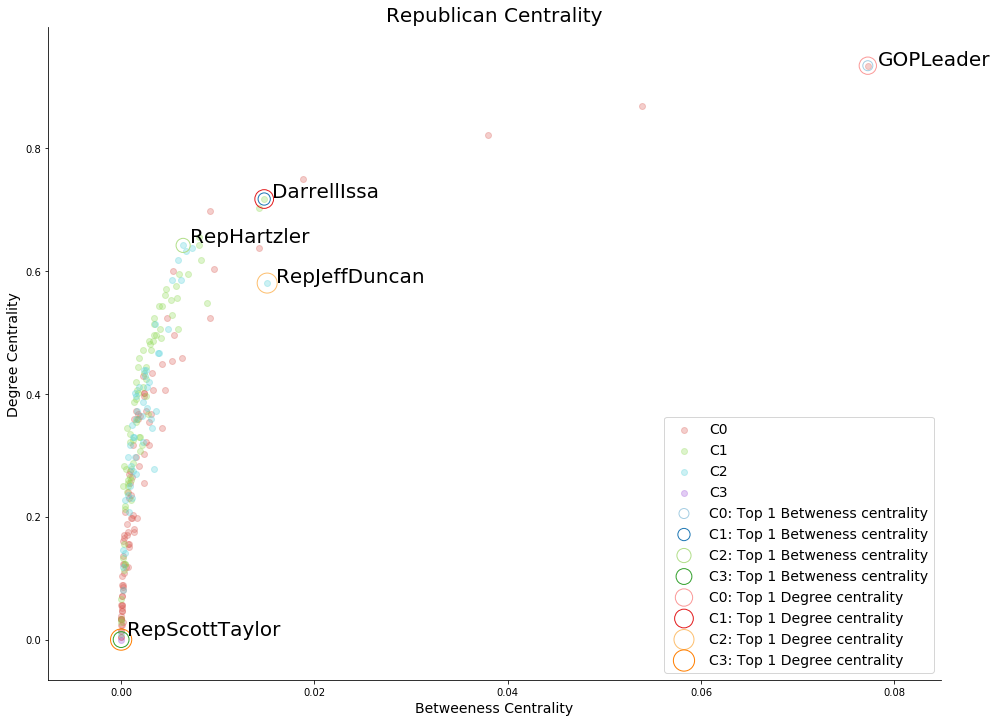

In [85]:
plt.figure(figsize = [16,12])

my_colors = sns.color_palette("hls", n_communities)
my_colors2 = sns.color_palette("Paired", len(onlyR_high_list))

labels = ["C0", "C1", "C2", "C3"]
labels2 = ["C0: Top 1 Betweness centrality","C1: Top 1 Betweness centrality","C2: Top 1 Betweness centrality","C3: Top 1 Betweness centrality",
           "C0: Top 1 Degree centrality","C1: Top 1 Degree centrality","C2: Top 1 Degree centrality","C3: Top 1 Degree centrality"]


for i in range(len(community_list)):
    plt.scatter(community_list[i].betweenness_cent, community_list[i].degree_cent, alpha = 0.3, color = my_colors[i], label = labels[i])

for j in range(len(onlyR_high_list)):
    plt.scatter(rep_net_stats[rep_net_stats.isin(onlyR_high_list[j])].betweenness_cent,
                rep_net_stats[rep_net_stats.isin(onlyR_high_list[j])].degree_cent,  
                s=100+j*50, facecolors='none', edgecolors=my_colors2[j], label = labels2[j])
    

    
#------------------------------------------------------------------------------------
#the whole count and if thing is just to avoide to much cluttering of names
count1 = 0
count2 = 0    
    
for k in R_all_top_1.rep:
    plt.annotate(k, xy=(R_all_top_1[R_all_top_1.rep == k]["betweenness_cent"] + 0.001 - count2
                        , R_all_top_1[R_all_top_1.rep == k]["degree_cent"] + count1 ),
                 fontsize = 20)     
    
    count1 += 0.0016
    count2 += 0.0001
# -------------------------------------------------------------------------------------    

plt.title("Republican Centrality", fontsize = 20)    

sns.despine()
plt.xlabel("Betweeness Centrality", fontsize = 14)
plt.ylabel("Degree Centrality", fontsize = 14)

plt.legend(fontsize = 14)

plt.savefig('R_net_BC_DC_scatter.pdf', bbox_inches="tight")
plt.show()  

In [86]:
# note Rep Scott Taylor is the only one in C3... Remove?

So can you check the jaccard similarity between the caucuses and the best partitions?

---

# R modularity:

In [87]:
# Jaccard:
jaccardR = list(nx.algorithms.link_prediction.jaccard_coefficient(GR))
jaccardR_df = pd.DataFrame(jaccardR)

jaccardR_df[3] = jaccardR_df[0] + "_" + jaccardR_df[1]
jaccardR_df.columns = {"pol_one":0,"pol_two":1,"jaccard":2, "dyad":3}
jaccardR_df.sample(6)

# Adamic
ademicR = list(nx.algorithms.link_prediction.adamic_adar_index(GR))
ademicR_df = pd.DataFrame(ademicR)

ademicR_df[3] = ademicR_df[0] + "_" + ademicR_df[1]
ademicR_df.columns = {"pol_one":0,"pol_two":1,"ademic":2, "dyad":3}


# Df to csv:
jaccardR_ademicR_df = ademicR_df.merge(jaccardR_df)
colsR = ['pol_one', 'pol_two', 'dyad', 'ademic', 'jaccard'] # get original: cols = jaccard_ademic_df.columns.tolist()
jaccardR_ademicR_df = jaccardR_ademicR_df[cols]

jaccardR_ademicR_df.to_csv("jaccardR_adamicR_df.csv")

# D only

In [88]:
D_caucus = dict(GD.nodes(data="caucus"))
modularity_D_caucus = community.modularity(D_caucus, GD)
print(modularity_D_caucus)

0.009881591773171924


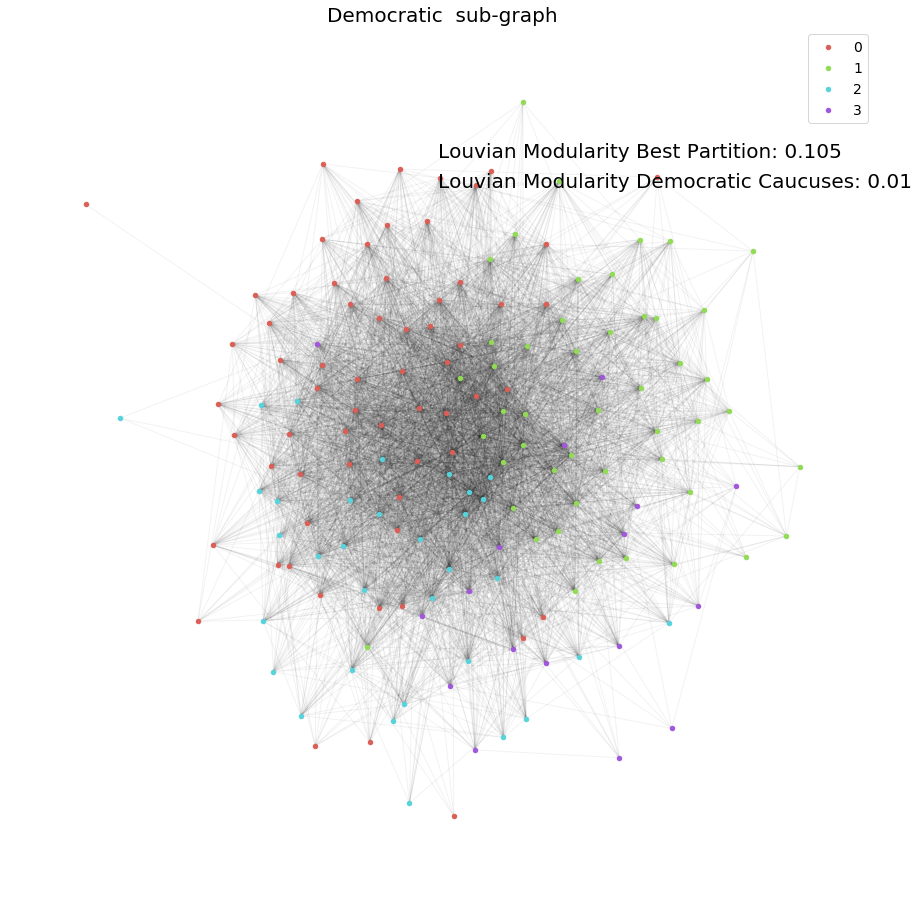

In [89]:
plt.axes([2,3,2,3])

communities = community.best_partition(GD)
modularity_best_pat = community.modularity(communities, GD) 

n_communities = len(set(list(communities.values())))
my_colors = sns.color_palette("hls", n_communities)
count = 0

pos=graphviz_layout(GD)

for com in set(communities.values()):
        list_nodes = [nodes for nodes in communities.keys() if communities[nodes] == com]
        
        nx.draw_networkx_nodes(GD, pos, list_nodes, node_size = 20, node_color = my_colors[count], label = str(com))
        
        count += 1

plt.text(-10, 100, "Louvian Modularity Best Partition: " + str(round(modularity_best_pat,3)), fontsize = 20)
plt.text(-10, 90, "Louvian Modularity Democratic Caucuses: " + str(round(modularity_D_caucus,3)), fontsize = 20)


nx.draw_networkx_edges(GD,pos, alpha=0.05)

plt.title("Democratic  sub-graph", fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(())
plt.yticks(())
sns.despine(left=True,bottom=True)
plt.savefig('Louvian_Dnet.pdf', bbox_inches="tight")


plt.show()

Find de mest centrale spillere i hver gruppe! (degreeness centrality?)

In [90]:
# Ja, det er lidt oprydning...

df_temp1 = df_house[["twitter_account", "party"]]
df_temp1.columns = {"twitter_id":"twitter_account", "party" : "party"}

df_temp2 = caucus_df[["twitter_id", "caucus"]]

df_temp3 = df_temp1.merge(df_temp2)
df_temp3.columns = {"rep":"twitter_account", "party" : "party", "caucus" : "caucus"}
df_temp3.columns 

Index(['rep', 'party', 'caucus'], dtype='object')

In [91]:
dem_DG = pd.DataFrame(pd.Series(dict(nx.degree(GD)))).reset_index().rename(columns={'index': 'rep', 0: 'degree'})
dem_DC = pd.DataFrame(pd.Series(nx.degree_centrality(GD))).reset_index().rename(columns={'index': 'rep', 0: 'degree_cent'})
dem_BC = pd.DataFrame(pd.Series(nx.betweenness_centrality(GD))).reset_index().rename(columns={'index': 'rep', 0: 'betweenness_cent'})
dem_COM = pd.DataFrame(pd.Series(communities)).reset_index().rename(columns={'index': 'rep', 0: 'Louvian_communities'})


dem_net_stats = dem_BC.merge(dem_DC)
dem_net_stats = dem_net_stats.merge(dem_DG)
dem_net_stats = dem_net_stats.merge(dem_COM)

dem_net_stats.sample(3)

,rep,betweenness_cent,degree_cent,degree,Louvian_communities
99,RepKClark,0.002842,0.397516,64,3
104,RepLindaSanchez,0.015066,0.751553,121,2
83,RepJayapal,0.003107,0.459627,74,1


In [92]:
# for later use.
dem_net_stats_w_caucus = dem_net_stats.merge(df_temp3, how = "inner")

## Similarity D

In [93]:
set(list(D_caucus.values()))

{'New Democrat Coalition',
 'Blue Collar Caucus',
 'Congressional Progressive Caucus',
 None}

In [112]:
D_cacus_num = []

for i in D_caucus:
    if D_caucus[i] == None:
        D_cacus_num.append(0)
    elif D_caucus[i] == "New Democrat Coalition":
         D_cacus_num.append(1)
    elif D_caucus[i] == "Congressional Progressive Caucus":
         D_cacus_num.append(2)
    elif D_caucus[i] == "Blue Collar Caucus":
         D_cacus_num.append(3)

print("sklearns")
print("Jaccard: ",jaccard_similarity_score(D_cacus_num,list(communities.values())))
print("Rand: ", adjusted_rand_score(D_cacus_num,list(communities.values())))

# the rand does not cra about the numbering of your communities... the Jaccard does here..

Jaccard:  0.2222222222222222
Rand:  0.03741218405008765


In [115]:
# Own implimentation of jaccard and rand - these you trust!


clusterA = D_cacus_num

clusterB = list(communities.values())

#-----------------------------------------------------

N = len(clusterA)
K = N*(N-1)/2

nums = list(range(N))

pairs_w_self = list(itertools.product(nums, nums))

pairs = []
used = []

for i, j in pairs_w_self:
    if i != j:
        if j not in used:
            pairs.append((i,j))
            used.append(i)

a = 0
b = 0
c = 0
d = 0


for i, j in pairs:
    A = (clusterA[i],clusterA[j])
    B = (clusterB[i],clusterB[j])
    
    if A[0] == A[1]:
        A_eq = 1
    else:
        A_eq = 0
        
    if B[0] == B[1]:
        B_eq = 1
    else:
        B_eq = 0
        
    if A_eq == 1 and B_eq == 1:
        a += 1
        
    if A_eq != 1 and B_eq == 1:
        b += 1
        
    if A_eq == 1 and B_eq != 1:
        c += 1

    if A_eq != 1 and B_eq != 1:
        d += 1
        
J = a/(K-d)
print("Jaccard = ", J)

#RI = (a+d)/(a+b+c+d) #same
RI = (a+d)/((N*(N-1)/2)) # AH! a+d!!!!
print("RI = ", RI)

Jaccard =  0.19055020205160086
RI =  0.6006441223832528


## Centrality D

In [95]:
# shit ass ugly blockcode - make a fucking function...
onlyD_high_DC_0 = dem_net_stats[dem_net_stats["Louvian_communities"]==0][["rep","degree_cent","betweenness_cent","Louvian_communities"]].sort_values("degree_cent", ascending=False)[:1]
onlyD_high_DC_1 = dem_net_stats[dem_net_stats["Louvian_communities"]==1][["rep","degree_cent","betweenness_cent","Louvian_communities"]].sort_values("degree_cent", ascending=False)[:1]
onlyD_high_DC_2 = dem_net_stats[dem_net_stats["Louvian_communities"]==2][["rep","degree_cent","betweenness_cent","Louvian_communities"]].sort_values("degree_cent", ascending=False)[:1]
onlyD_high_DC_3 = dem_net_stats[dem_net_stats["Louvian_communities"]==3][["rep","degree_cent","betweenness_cent","Louvian_communities"]].sort_values("degree_cent", ascending=False)[:1]
#onlyD_high_DC_4 = dem_net_stats[dem_net_stats["Louvian_communities"]==4][["rep","degree_cent","betweenness_cent","Louvian_communities"]].sort_values("degree_cent", ascending=False)[:1]


onlyD_high_BC_0 = dem_net_stats[dem_net_stats["Louvian_communities"]==0][["rep","degree_cent","betweenness_cent","Louvian_communities"]].sort_values("betweenness_cent", ascending=False)[:1]
onlyD_high_BC_1 = dem_net_stats[dem_net_stats["Louvian_communities"]==1][["rep","degree_cent","betweenness_cent","Louvian_communities"]].sort_values("betweenness_cent", ascending=False)[:1]
onlyD_high_BC_2 = dem_net_stats[dem_net_stats["Louvian_communities"]==2][["rep","degree_cent","betweenness_cent","Louvian_communities"]].sort_values("betweenness_cent", ascending=False)[:1]
onlyD_high_BC_3 = dem_net_stats[dem_net_stats["Louvian_communities"]==3][["rep","degree_cent","betweenness_cent","Louvian_communities"]].sort_values("betweenness_cent", ascending=False)[:1]
#onlyD_high_BC_4 = dem_net_stats[dem_net_stats["Louvian_communities"]==4][["rep","degree_cent","betweenness_cent","Louvian_communities"]].sort_values("betweenness_cent", ascending=False)[:1]

# onlyD_high_list = [onlyD_high_DC_0, onlyD_high_DC_1, onlyD_high_DC_2, onlyD_high_DC_3, onlyD_high_DC_4,
#                    onlyD_high_BC_0, onlyD_high_BC_1, onlyD_high_BC_2, onlyD_high_BC_3, onlyD_high_BC_4]


onlyD_high_list = [onlyD_high_DC_0, onlyD_high_DC_1, onlyD_high_DC_2, onlyD_high_DC_3,
                   onlyD_high_BC_0, onlyD_high_BC_1, onlyD_high_BC_2, onlyD_high_BC_3]

C0 = dem_net_stats[dem_net_stats.Louvian_communities == 0]
C1 = dem_net_stats[dem_net_stats.Louvian_communities == 1]
C2 = dem_net_stats[dem_net_stats.Louvian_communities == 2]
C3 = dem_net_stats[dem_net_stats.Louvian_communities == 3]
#C4 = dem_net_stats[dem_net_stats.Louvian_communities == 4]


#community_list = [C0, C1, C2, C3, C4]
community_list = [C0, C1, C2, C3]


D_all_top_1 = reduce(lambda left,right: pd.merge(left,right, how= "outer"), onlyD_high_list) # for plot anotation 
D_all_top_1.sort_values("betweenness_cent", ascending= False , inplace=True)


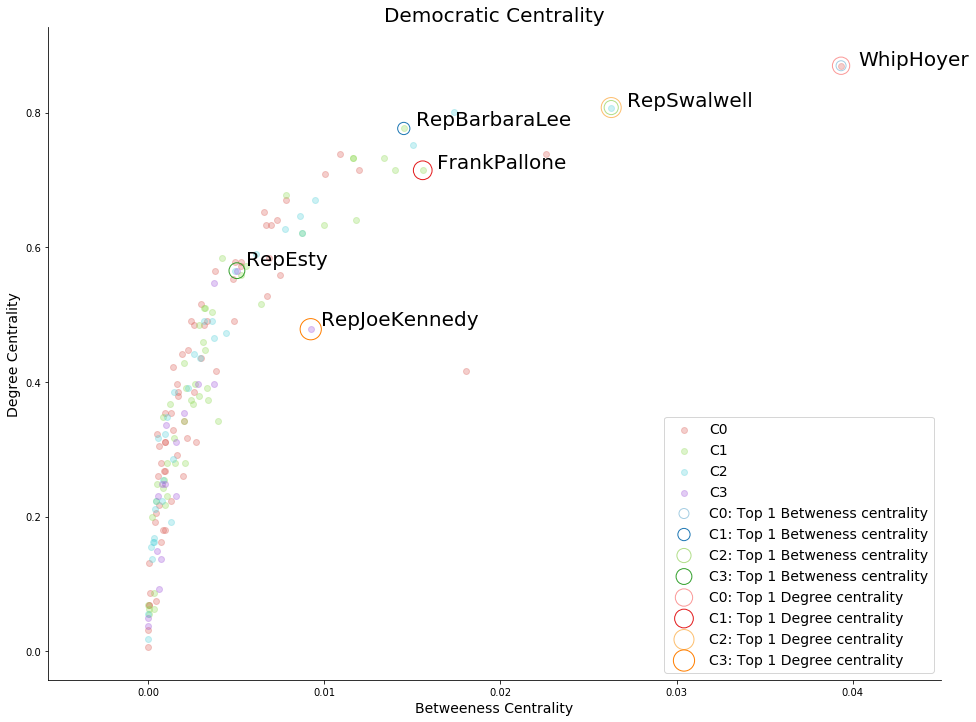

In [96]:
plt.figure(figsize = [16,12])

my_colors = sns.color_palette("hls", n_communities)
my_colors2 = sns.color_palette("Paired", len(onlyD_high_list))

labels = ["C0", "C1", "C2", "C3"]

labels2 = ["C0: Top 1 Betweness centrality","C1: Top 1 Betweness centrality",
           "C2: Top 1 Betweness centrality","C3: Top 1 Betweness centrality",
           "C0: Top 1 Degree centrality","C1: Top 1 Degree centrality",
           "C2: Top 1 Degree centrality","C3: Top 1 Degree centrality"]


for i in range(len(community_list)):
    plt.scatter(community_list[i].betweenness_cent, community_list[i].degree_cent, alpha = 0.3, color = my_colors[i], label = labels[i])

for j in range(len(onlyD_high_list)):
    plt.scatter(dem_net_stats[dem_net_stats.isin(onlyD_high_list[j])].betweenness_cent,
                dem_net_stats[dem_net_stats.isin(onlyD_high_list[j])].degree_cent,  
                s=100+j*50, facecolors='none', edgecolors=my_colors2[j], label = labels2[j])
    

    

#------------------------------------------------------------------------------------
#the whole count and if thing is just to avoide to much cluttering of names
count1 = 0
count2 = 0    
    
for k in D_all_top_1.rep:
    if k in ["RepEBJ"]: # Might change as you get more data!
        plt.annotate(k, xy=(D_all_top_1[D_all_top_1.rep == k]["betweenness_cent"] + 0.001 - count2
                         , D_all_top_1[D_all_top_1.rep == k]["degree_cent"] - count1 ), 
                    fontsize = 20)     
        
    else:
        plt.annotate(k, xy=(D_all_top_1[D_all_top_1.rep == k]["betweenness_cent"] + 0.001 - count2
                         , D_all_top_1[D_all_top_1.rep == k]["degree_cent"] + count1 ), 
                    fontsize = 20)     
    
    count1 += 0.0016
    count2 += 0.0001
# -------------------------------------------------------------------------------------    

    
    
plt.title("Democratic Centrality", fontsize = 20)    
sns.despine()
plt.xlabel("Betweeness Centrality", fontsize = 14)
plt.ylabel("Degree Centrality", fontsize = 14)


plt.legend(fontsize = 14)

plt.savefig('D_net_BC_DC_scatter.pdf', bbox_inches="tight")
plt.show()  

In [97]:
# Finding the two other C0 with very high BC:

dem_net_stats[dem_net_stats["Louvian_communities"] == 0].sort_values("betweenness_cent", ascending= False).iloc[1:3]

,rep,betweenness_cent,degree_cent,degree,Louvian_communities
19,NancyPelosi,0.022606,0.739130,119,0
93,RepJohnLarson,0.018034,0.416149,67,0


# D modularity:

In [98]:
# Jaccard:
jaccardD = list(nx.algorithms.link_prediction.jaccard_coefficient(GD))
jaccardD_df = pd.DataFrame(jaccardD)

jaccardD_df[3] = jaccardD_df[0] + "_" + jaccardD_df[1]
jaccardD_df.columns = {"pol_one":0,"pol_two":1,"jaccard":2, "dyad":3}
jaccardD_df.sample(6)

# Adamic
ademicD = list(nx.algorithms.link_prediction.adamic_adar_index(GD))
ademicD_df = pd.DataFrame(ademicD)

ademicD_df[3] = ademicD_df[0] + "_" + ademicD_df[1]
ademicD_df.columns = {"pol_one":0,"pol_two":1,"ademic":2, "dyad":3}


# Df to csv:
jaccardD_ademicD_df = ademicD_df.merge(jaccardD_df)
colsD = ['pol_one', 'pol_two', 'dyad', 'ademic', 'jaccard'] # get original: cols = jaccard_ademic_df.columns.tolist()
jaccardD_ademicD_df = jaccardD_ademicD_df[cols]

jaccardD_ademicD_df.to_csv("jaccardD_adamicD_df.csv")

# work in progress:

In [99]:
set(list(D_caucus.values()))

{'New Democrat Coalition',
 'Blue Collar Caucus',
 'Congressional Progressive Caucus',
 None}

In [100]:
set(list(R_caucus.values()))

{'Republican Main Street Partnership',
 'Tuesday Group',
 'Liberty Caucus',
 'Freedom Caucus',
 None,
 'Republican Study Committee'}

In [101]:
list(communities.values())

[0,
 1,
 0,
 0,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 3,
 3,
 0,
 0,
 0,
 0,
 1,
 2,
 1,
 0,
 1,
 3,
 1,
 2,
 1,
 0,
 1,
 2,
 1,
 0,
 1,
 3,
 0,
 2,
 0,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 2,
 0,
 0,
 3,
 1,
 1,
 0,
 1,
 0,
 0,
 3,
 0,
 1,
 2,
 2,
 0,
 0,
 2,
 1,
 1,
 2,
 2,
 0,
 1,
 2,
 1,
 0,
 1,
 0,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 0,
 1,
 1,
 1,
 3,
 1,
 0,
 0,
 0,
 3,
 2,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 3,
 0,
 0,
 2,
 3,
 0,
 2,
 3,
 0,
 0,
 0,
 0,
 2,
 0,
 3,
 1,
 0,
 2,
 2,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 2,
 1,
 0,
 0,
 3,
 0,
 0,
 0,
 3,
 2,
 0,
 2,
 3]

In [102]:
D_caucus["BennieGThompson"]

'Congressional Progressive Caucus'

In [103]:
D_cacus_num = []

for i in D_caucus:
    if D_caucus[i] == None:
        D_cacus_num.append(0)
    elif D_caucus[i] == "New Democrat Coalition":
         D_cacus_num.append(1)
    elif D_caucus[i] == "Congressional Progressive Caucus":
         D_cacus_num.append(2)
    elif D_caucus[i] == "Blue Collar Caucus":
         D_cacus_num.append(3)
            
print("Jaccard: ",jaccard_similarity_score(D_cacus_num,list(communities.values())))
print("Rand: ", adjusted_rand_score(D_cacus_num,list(communities.values())))

Jaccard:  0.30246913580246915
Rand:  0.03741218405008765
